## Problem Statement

We want to explore alternative methods for predicting the orbital positions and potential collisions among satellites within the congested environment of Low Earth Orbit (LEO).

In addressing the complexities of Low Earth Orbit (LEO), we confront the uncertainties from current parameter estimations. The proliferation of space debris and the escalating satellite density have introduced considerable challenges in accurately forecasting orbital trajectories and potential collisions. We want to construct a predictive model to accommodate the inherent disorder and uncertainties prevalent in LEO.

As of November 2023, the number of satellites in LEO has reached a substantial count of 4059 according to data from [Space Debris Database](https://space.oscar.wmo.int/satellites). While some satellites possess the capability for refueling to maintain their orbits, a considerable portion are not designed for refueling and ultimately reach the end of their operational lifespan. Upon depletion of their fuel reserves, these satellites become retired and are either deliberately deorbited through controlled re-entry, burning up in the Earth's atmosphere, or directed into designated 'spacecraft cemeteries' [NASA's spacecraft graveyard](https://spaceplace.nasa.gov/spacecraft-graveyard/en/).

Contrarily, operational LEO satellites undergo periodic adjustments in their orbits, varying from minor corrections occurring between weekly to yearly intervals. This adjustment is essential for sustaining their orbital positions and avoiding potential collisions. For instance, the International Space Station (ISS) undergoes periodic altitude adjustments as evidenced by its fluctuating height over the past year, observable through data such as that provided by [Heavens Above](https://www.heavens-above.com/IssHeight.aspx).


## What is [TLE](https://en.wikipedia.org/wiki/Two-line_element_set)
TLE, or Two-Line Element set, is a standardized format used to encapsulate the position and velocity information of Earth-orbiting objects at a specific time. It serves as a snapshot providing crucial data about the trajectory and orbit of satellites or space debris, but it's only valid [within 5-10 days](https://service.eumetsat.int/tle/#:~:text=METOP%2C%20NOAA%2C%20SUOMI%20TLEs&text=Their%20validity%20arc%20spans%20from,similar%20accuracy%20for%20several%20weeks.).

This format is presented in text files, featuring two lines of 69-column ASCII characters, prefaced by a title line that identifies the object in focus. The first line of a TLE includes details like the satellite's identification number, epoch time, and coefficients representing orbital parameters. The second line contains additional orbital elements such as inclination, eccentricity, argument of perigee, mean anomaly, mean motion, and other pertinent data necessary for precise position calculations.


So for example, a TLE from International Space Station looks like this:
```
ISS (ZARYA)             
1 25544U 98067A   23346.67906868  .00008908  00000+0  16188-3 0  9999
2 25544  51.6402 164.4314 0001234  45.5486  50.9340 15.50349770429473
```

Here's the parameters that Two-Line Element set (TLE) used to describe satellite orbits:

1. **Satellite Identification Number:** A unique identifier assigned to a specific satellite for tracking and cataloging purposes.

2. **Epoch Time:** The moment at which the TLE was generated, indicating the time to which the orbital parameters refer.

3. **Orbital Parameters Coefficients:** These coefficients represent values used in mathematical formulas to define the satellite's orbital path, including adjustments for atmospheric drag and gravitational perturbations.

4. **Inclination:** The angle between the orbital plane of the satellite and the equatorial plane of the Earth, determining the tilt of the satellite's orbit.

5. **Eccentricity:** Describes the shape of the satellite's orbit, indicating how much it deviates from a perfect circle. Values range from 0 (circular) to 1 (highly elliptical).

6. **Argument of Perigee:** Defines the angle between the ascending node (where the satellite crosses the equatorial plane going north) and the point of closest approach to the Earth.

7. **Mean Anomaly:** Specifies the satellite's angular position along its elliptical orbit at a specific time relative to the point of perigee.

8. **Mean Motion:** Indicates the average angular velocity of the satellite along its orbit, measured in revolutions per day.

These TLE sets are widely utilized by satellite tracking systems, research institutions, and space agencies to forecast future satellite positions, aiding in collision avoidance strategies, mission planning, and orbital analyses in the increasingly crowded Low Earth Orbit environment.

## Why Bayesians might work?

The escalating number of objects in Low Earth Orbit (LEO) heightens the risk of collisions, exacerbating the creation of space debris and the potential for the [Kessler Syndrome](https://www.space.com/kessler-syndrome-space-debris#:~:text=The%20Kessler%20Syndrome%20is%20a,satellites%2C%20astronauts%20and%20mission%20planners.). This cycle poses severe threats to operational satellites and the viability of future space missions by rendering orbits unusable due to debris accumulation. Predicting space collisions necessitates trajectory calculations and evaluating collision probabilities. While traditional mathematical methods offer precision, they demand accurate position and velocity data for each object, often limited by uncertainties in tracking smaller debris.

Bayesian methods offers an alternative approach to precise mathematical calculations due to its ability to incorporate uncertainties and account for incomplete or imperfect data. Here are reasons why Bayesian methods could be advantageous in predicting collisions compared to traditional precise mathematical calculations:

1. **Accounting for Uncertainties:** In space, obtaining precise and complete data on all orbital parameters of objects is challenging due to various factors like tracking errors, irregular gravitational influences, and incomplete observational data. Bayesian methods excel in handling uncertainties inherent in such situations. They allow for the incorporation of prior knowledge or beliefs about the variables involved, and as new data becomes available, they continuously update the predictions through posterior probabilities. This approach helps in producing more realistic estimations of collision probabilities, even with imperfect or incomplete information.

2. **Adaptability and Continuous Learning:** Bayesian methods excel in versatile modeling, accommodating complex interactions among space objects while continuously learning from diverse data sources. This adaptability enables them to assess collision risks in dynamic Low Earth Orbit (LEO) environments by considering evolving factors like object positions and environmental changes.

3. **Decision-Making Under Uncertainty:** Space missions often require critical decision-making regarding collision avoidance maneuvers or satellite repositioning. Bayesian methods provide not only predictions but also probabilistic distributions, enabling decision-makers to assess the level of risk and make informed decisions under uncertainty.

In summary, exploring Bayesian methods for collision prediction in space offers a more robust and adaptable approach compared to precise mathematical calculations by effectively handling uncertainties, incorporating prior knowledge, adapting to new information, and enabling informed decision-making in a dynamically changing orbital environment.

In [3]:
from google.colab import files

# Upload files to? Colab
uploaded = files.upload()


Saving satellite_data.txt to satellite_data (2).txt


In [4]:
!pip install skyfield
!pip install poliastro
!pip install tle-tools

In [5]:
import csv
from skyfield.api import load, EarthSatellite, Topos
from datetime import datetime, timedelta
from skyfield.api import load
import numpy as np
import pymc as pm
from poliastro.constants import GM_earth
from astropy import units as u
import matplotlib.pyplot as plt
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from poliastro.twobody.propagation import propagate
from astropy import units as u
from astropy.time import Time
import plotly.graph_objs as go
import pandas as pd
import re
from tletools import TLE
import numpy as np
import plotly.graph_objects as go
from datetime import timedelta

# Assumptions and Limitations in this Project

1. Only using Geosynchronus satellite data from CELESTREK - https://celestrak.org/NORAD/elements/gp.php?GROUP=geo&FORMAT=tle

2. We aren't plotting all the traces for a satellite as generated by our MONTE CARLO model. Instead, we introduce uncertainity into it and then take the mean values for each parameter that helps determine orbital parameters

In [9]:
# Function to create an EarthSatellite object
def create_earth_satellite(tle_line1, tle_line2, satellite_name):
    ts = load.timescale()
    #current_time = ts.now()
    return EarthSatellite(tle_line1, tle_line2, satellite_name, load.timescale())

# Function to extract parameters from TLE lines
def extract_parameters_from_tle(tle_line1, tle_line2):
    line1_parts = re.split(r'\s+', tle_line1)
    line2_parts = re.split(r'\s+', tle_line2)

    # Extracting B* value
    b_star_raw = tle_line1[53:61].strip()
    #b_star_exp = int(b_star_raw[-2:])
    b_star = float(b_star_raw[:-2]) #* (10 ** b_star_exp)

    # Extracting International Designator
    international_designator = tle_line1[9:17].strip()

    parameters = {
        'norad_number': line1_parts[1],
        'international_designator': international_designator,
        'epoch_year': line1_parts[3][:2],
        'epoch_day': line1_parts[3][2:],
        'inclination': float(line2_parts[2]),
        'ra_of_asc_node': float(line2_parts[3]),
        'eccentricity': float("0." + line2_parts[4]),
        'arg_of_pericenter': float(line2_parts[5]),
        'mean_anomaly': float(line2_parts[6]),
        'mean_motion': float(line2_parts[7]),
        'b_star': b_star
    }
    return parameters


path_to_data_file = 'satellite_data.txt'

# Dictionaries to store the satellite objects and their raw parameters
satellites = {}
satellite_parameters = {}

# Read TLE Data
with open(path_to_data_file, 'r') as file:
    lines = file.readlines()

# Process TLE data
i = 0
tle_dict = {}
while i < len(lines):
    satellite_name = lines[i].strip()
    tle_line1 = lines[i+1].strip()
    tle_line2 = lines[i+2].strip()
    i += 3

    #TLE object
    tle = TLE.from_lines(line1=tle_line1, line2=tle_line2, name=satellite_name)
    tle_dict[satellite_name] = tle

    # Create EarthSatellite
    satellite = create_earth_satellite(tle_line1, tle_line2, satellite_name)
    satellites[satellite_name] = satellite

    # Extract and store parameters for the purpose of statistical analysis
    satellite_parameters[satellite_name] = extract_parameters_from_tle(tle_line1, tle_line2)

#print(satellites)
#print(satellite_parameters)
#print(tle_dict)


In [10]:
#Using a lbrary called Skyfield in-order to plot the trajectories of the different satellites without introducing variance to the original TLE data

def plot_satellite_trajectories(satellites, hours_ahead=7):

    ts = load.timescale()

    fig = go.Figure()
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'yellow', 'cyan', 'magenta']

    #print(satellites.items())

    # Loop through the satellites and plot their current position and orbit trajectory
    for index, (satellite_name, satellite) in enumerate(satellites.items()):
        color = colors[index % len(colors)]  # Cycle through the color list

        start_time = satellite.epoch
        end_time = start_time + timedelta(hours=hours_ahead)  # Convert hours to days

        #print(start_time,end_time)

        # Calculate the satellite's position at the start time
        geocentric = satellite.at(start_time).position.km
        fig.add_trace(go.Scatter3d(
            x=[geocentric[0]], y=[geocentric[1]], z=[geocentric[2]],
            mode='markers', marker=dict(size=5, color=color), name=f'{satellite_name} Current Position'
        ))

        # Generate the times for the trajectory
        time_intervals = np.linspace(start_time.tt, end_time.tt, num=200)  #Generating 200 time intervals for an accurate trajectory
        times = ts.tt_jd(time_intervals)

        # Calculate the satellite's trajectory from the start time to the end time
        trajectory = satellite.at(times).position.km
        fig.add_trace(go.Scatter3d(
            x=trajectory[0], y=trajectory[1], z=trajectory[2],
            mode='lines', name=f'{satellite_name} Orbit Trajectory', line=dict(color=color)
        ))

    return fig

    fig.update_layout(
        title="Current Position and Orbital Trajectory of Satellites",
        scene=dict(
            xaxis=dict(title="X (km)"),
            yaxis=dict(title="Y (km)"),
            zaxis=dict(title="Z (km)")
        ),
        showlegend=True
    )

    fig.show()


In [11]:
#Calling this on original RAW TLE data
plot_satellite_trajectories(satellites)


**The Intuition of the model**

Probabilistic approach to model the orbits of satellites. Traditional deterministic models would use single point estimates for parameters like mean motion, eccentricity, etc. However, this approach acknowledges uncertainties in these parameters and models them as probability distributions. This allows for a more robust understanding of the range of possible orbits for each satellite, considering uncertainties and variabilities in their orbital parameters.

The Monte Carlo Model runs the simulation on every single satellite as opposed to running a simualtion on all satellites.

In [12]:
# Gravitational constant that is converted to units of kilometers cubed per second squared. It's a constant used in orbital mechanics calculations.
GM_earth_km3_s2 = GM_earth.to(u.km**3 / u.s**2).value

# This dictionary will store the trace for each and every satellite
satellite_traces = {}

for satellite_name, params in satellite_parameters.items():
    with pm.Model() as model:
        # Realistic priors for the uncertain parameters
        mean_motion = pm.Normal('mean_motion', mu=params['mean_motion'], sigma=0.1)

        # Beta distribution for eccentricity, Emphasize lower eccentricity
        ecc = pm.Beta('ecc', alpha=1, beta=30, mu=params['eccentricity'], sigma=0.0005)

        # Inclination too is typically low for geosynchronous orbits, so a smaller standard deviation
        inc = pm.Normal('inc', mu=params['inclination'], sigma=0.05)

        # RAAN and argp could have smaller standard deviations due to the specific nature of geosynchronous orbits
        raan = pm.Normal('raan', mu=params['ra_of_asc_node'], sigma=0.05)
        argp = pm.Normal('argp', mu=params['arg_of_pericenter'], sigma=0.05)

        # True Anomaly might also have less variation
        nu = pm.Normal('nu', mu=params['mean_anomaly'], sigma=0.05)


        # Convert mean motion from rev/day to rad/s
        mean_motion_rads_per_day = mean_motion * 2 * np.pi
        mean_motion_rads_per_sec = mean_motion_rads_per_day / (24 * 3600)

        # Semi-major axis calculation from mean motion
        a = pm.Deterministic('a', (GM_earth_km3_s2 / mean_motion_rads_per_sec**2)**(1/3))

        # Sampling 1000 points with a burn in of 500 points
        trace = pm.sample(1000, tune=500)

        satellite_traces[satellite_name] = trace


In [14]:
#Statistical Analysis goes here on considered parameters
for satellite_name, trace in satellite_traces.items():
    print(f"Satellite: {satellite_name}")
    print(pm.summary(trace))

Satellite: TDRS 3
                  mean        sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
mean_motion      1.006     0.102      0.819      1.187      0.002    0.002   
inc             13.311     0.053     13.209     13.406      0.001    0.001   
raan           347.267     0.050    347.174    347.357      0.001    0.001   
argp           333.094     0.051    332.988    333.181      0.001    0.001   
nu              36.748     0.051     36.654     36.845      0.001    0.001   
ecc              0.032     0.031      0.000      0.089      0.001    0.001   
a            42332.200  2936.785  37631.428  48156.083     61.412   43.859   

             ess_bulk  ess_tail  r_hat  
mean_motion    2347.0    1299.0    1.0  
inc            2630.0    1463.0    1.0  
raan           2496.0    1364.0    1.0  
argp           3013.0    1485.0    1.0  
nu             2010.0    1209.0    1.0  
ecc            2221.0    1250.0    1.0  
a              2347.0    1299.0    1.0  
Satellite: FLTSATCOM 8 (USA 4

Plotting the autocorrelation plot for a single satellite. The reason is because since all satellites used are active_geosynchronus satellites that are essentially low orbit satellites, they all are likely to be mdoelled the same way. This is also something we verfied by running the autocorellation plot for multiple satellites.

The code for that is as follows: (Simply replace and run in the next cell)

:   for satellite_name, idata in satellite_traces.items():
    print(f"Analysis for {satellite_name}")

    # Traceplot for visualizing the sampled values of each parameter
    az.plot_trace(idata)
    plt.show()

    # Plotting the posterior for each parameter
    var_names = list(idata.posterior.data_vars)
    for varname in var_names:
        az.plot_posterior(idata, var_names=varname)
        plt.title(f"Posterior of {varname} for {satellite_name}")
        plt.show()

    # Autocorrelation plot for each sampled parameter
    az.plot_autocorr(idata)
    plt.show()

Analysis for TDRS 3


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



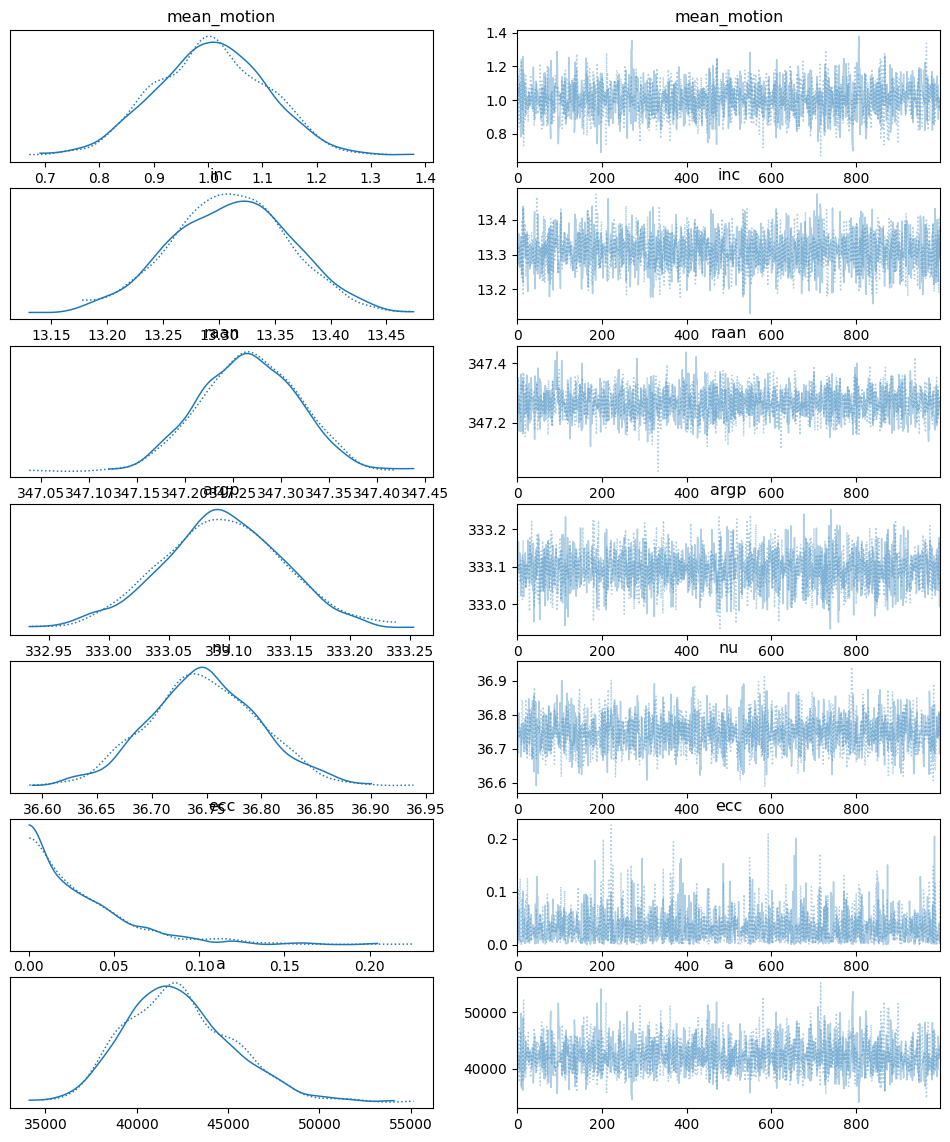

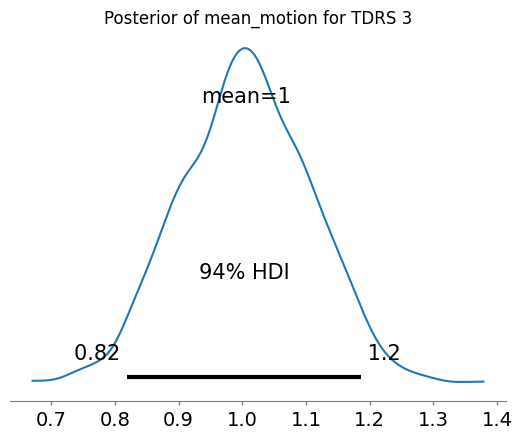

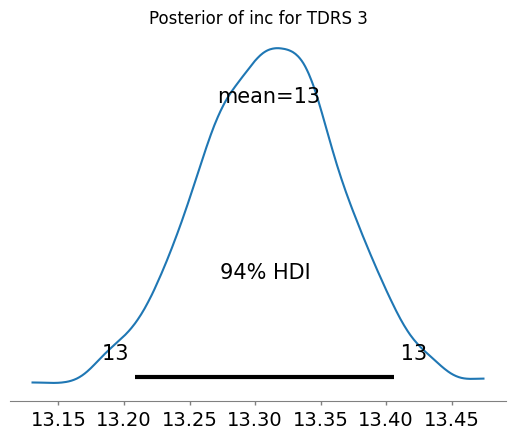

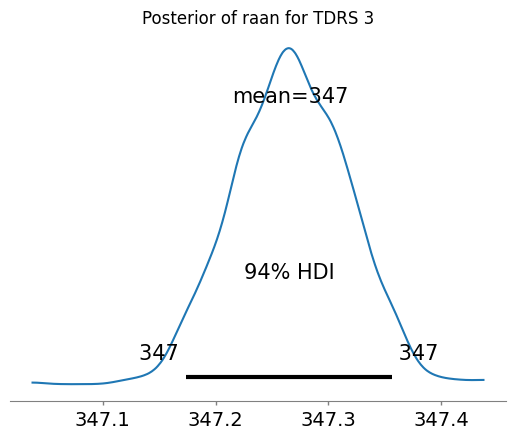

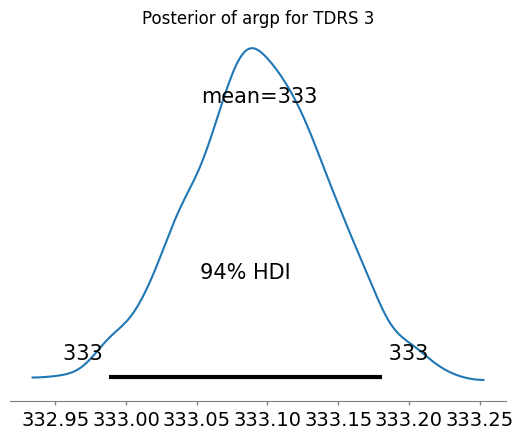

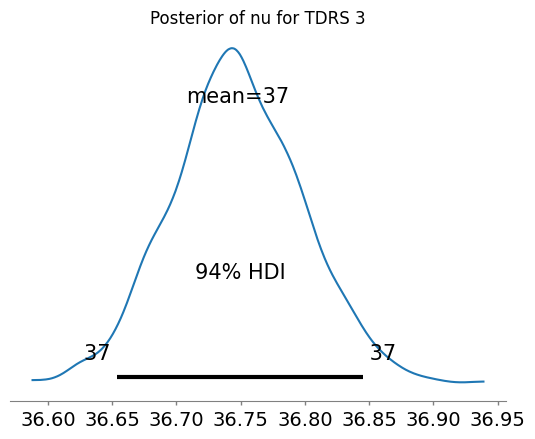

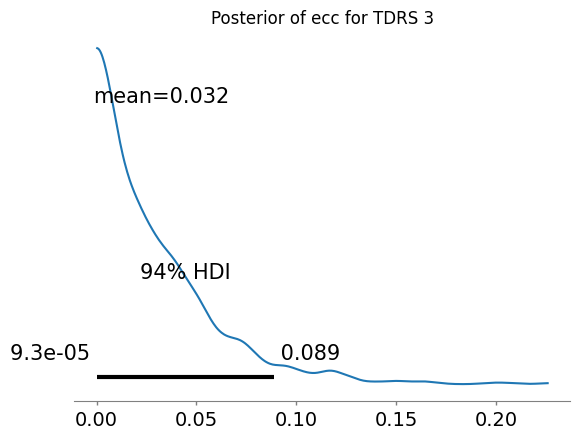

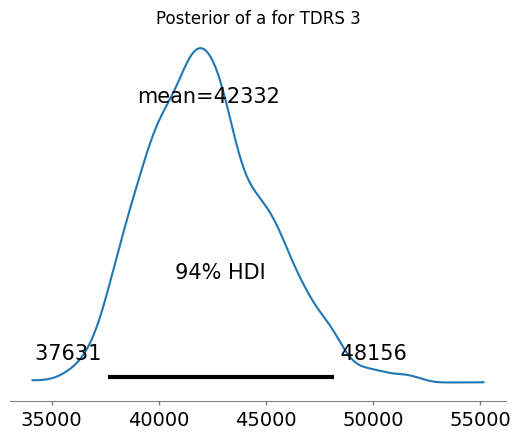

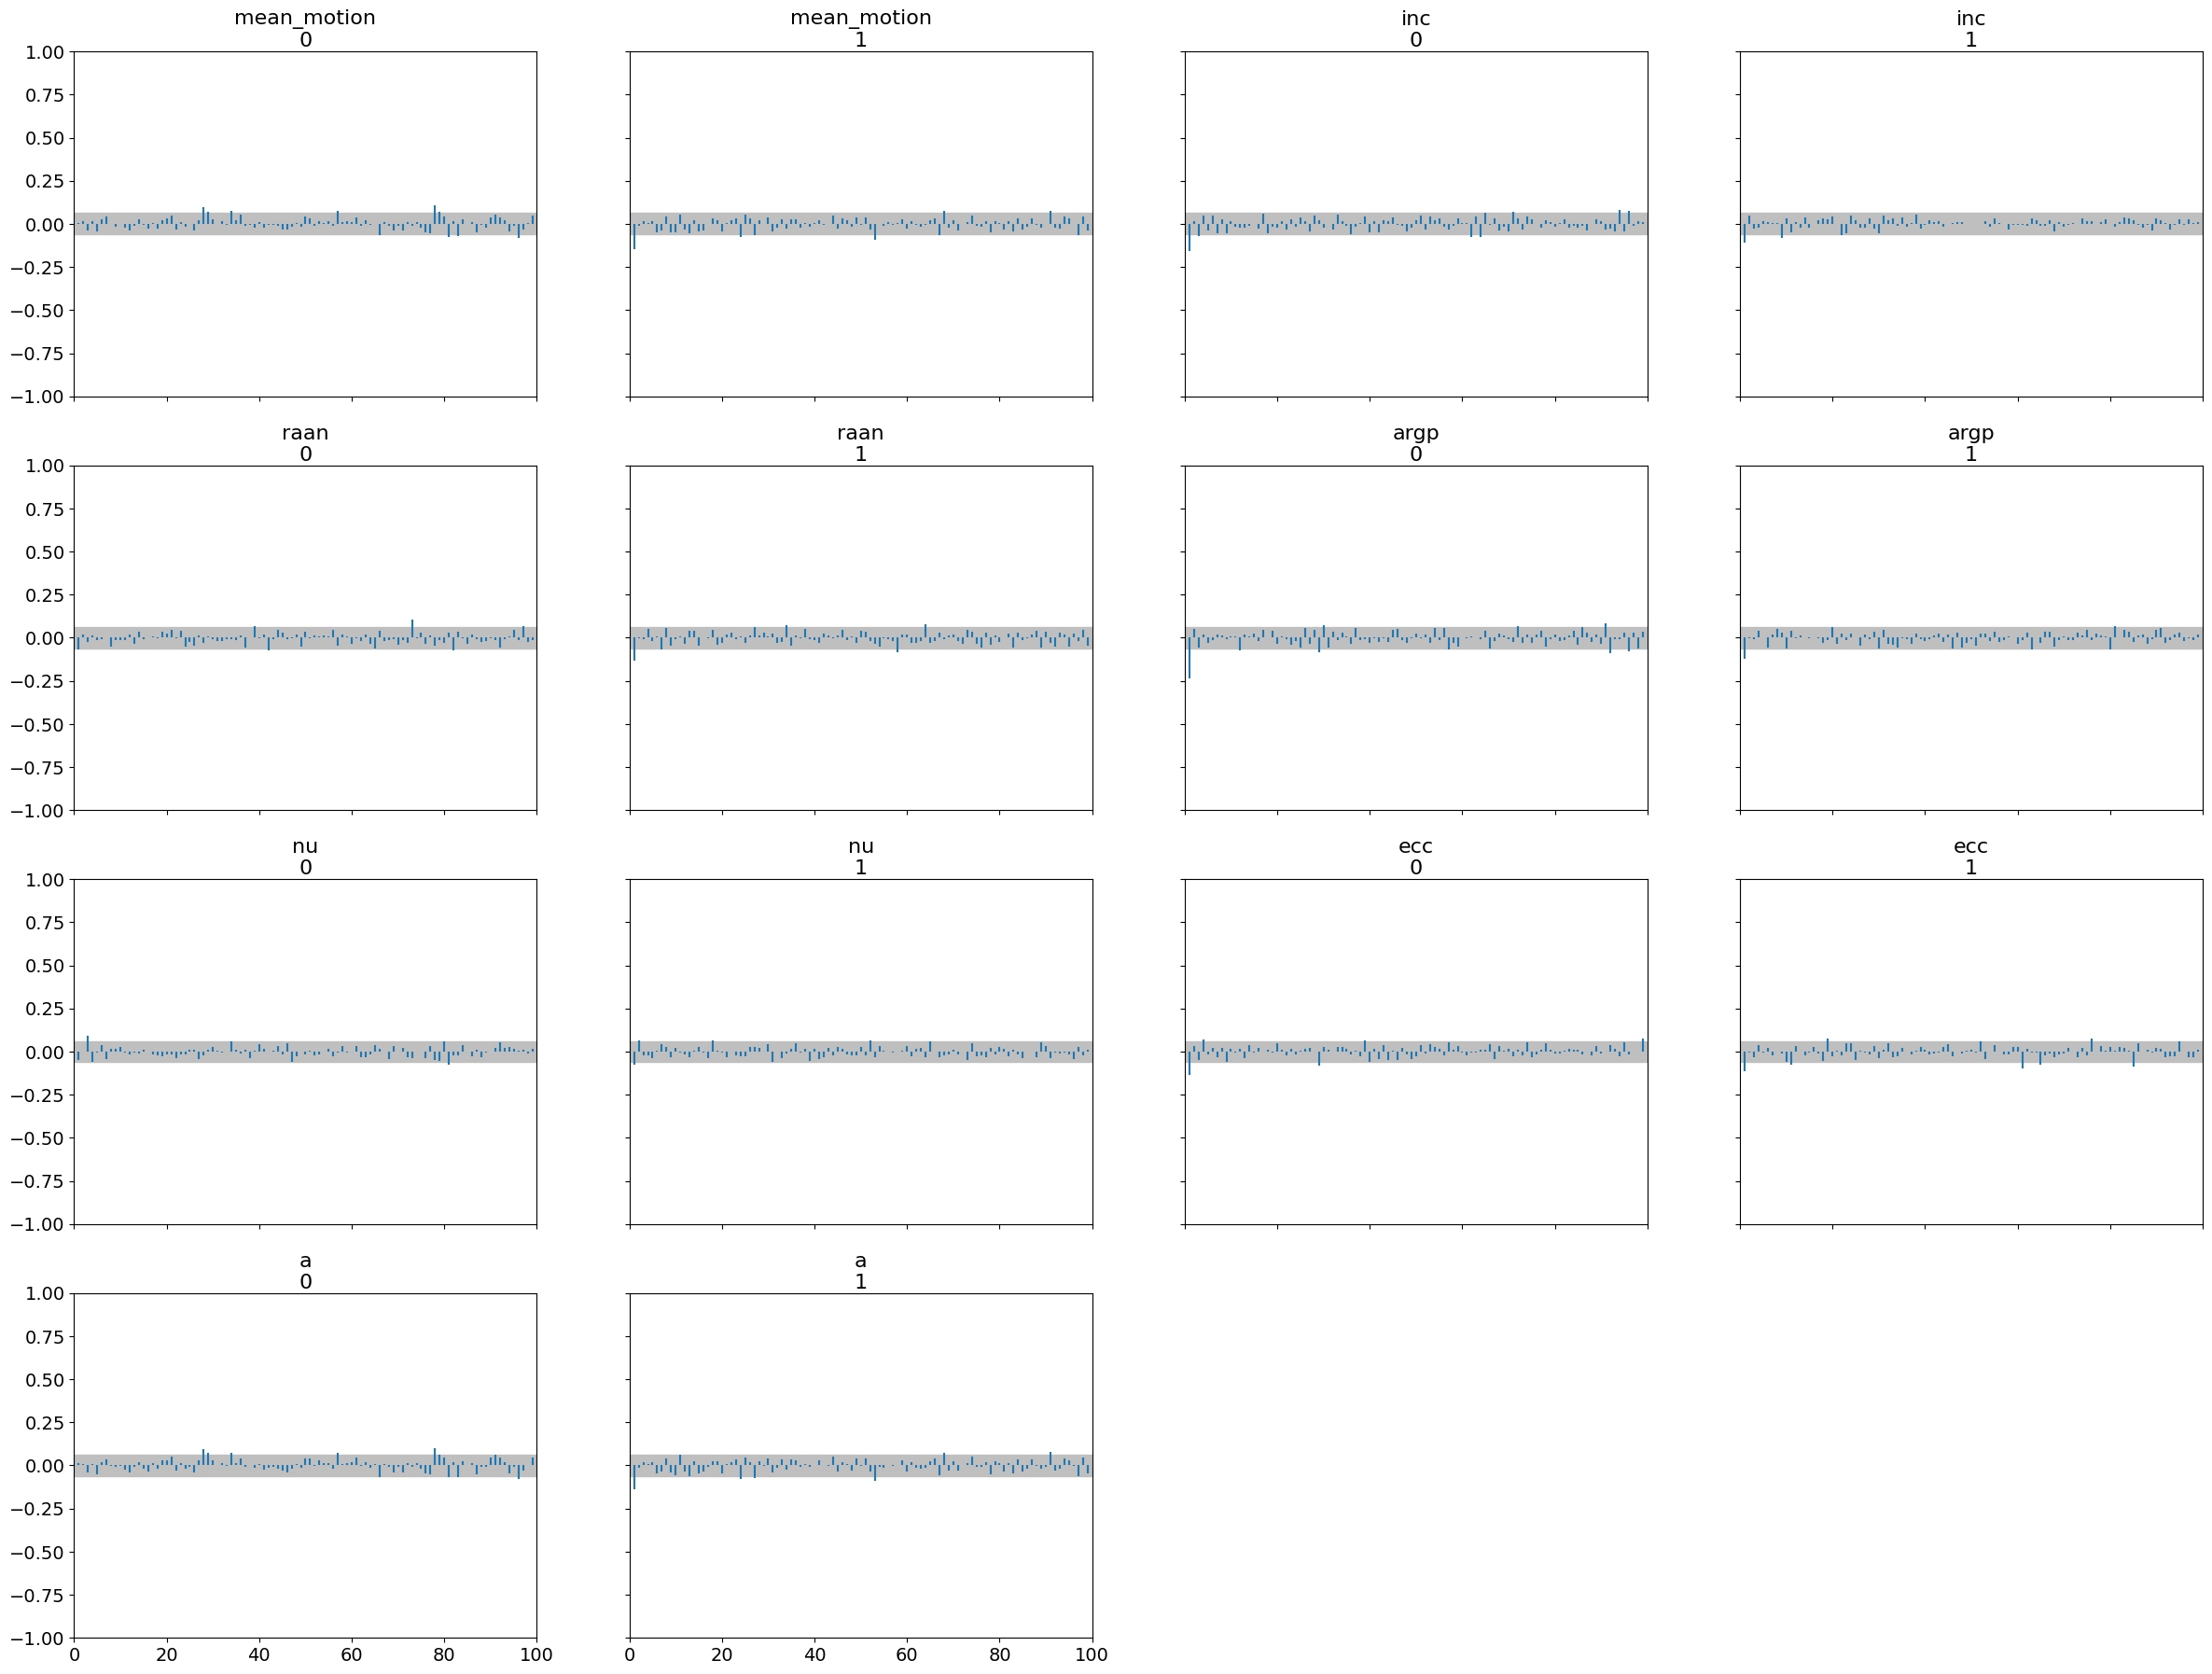

In [15]:
import arviz as az
import matplotlib.pyplot as plt

satellite_name = 'TDRS 3'
idata = satellite_traces[satellite_name]

print(f"Analysis for {satellite_name}")

# Traceplot for visualizing the sampled values of each parameter for a single satellite
az.plot_trace(idata)
plt.show()

# Plotting the posterior for each parameter
var_names = list(idata.posterior.data_vars)
for varname in var_names:
    az.plot_posterior(idata, var_names=varname)
    plt.title(f"Posterior of {varname} for {satellite_name}")
    plt.show()

# Autocorrelation plot for each sampled parameter
az.plot_autocorr(idata, var_names=var_names)
plt.show()


## **Inferring the graphs above**

mean_motion: The posterior distribution is centered around a particular value with a symmetric spread, indicating that the mean motion has a well-defined average value with some uncertainty. The trace plot shows good 'mixing', with the values exploring the space well without obvious patterns or convergence issues, which is a sign of a well-performing MCMC.

ecc (Eccentricity): The density plot suggests that the most probable values for eccentricity are low, which is consistent with the expectation that many satellites have near-circular orbits (eccentricity close to 0). The trace plot shows that the parameter values are varying quite widely across the samples, which could indicate either exploration of the space or high uncertainty.

inc (Inclination): The posterior for inclination seems to be uniformly distributed between lower and upper bounds, suggesting that there is no strong data-driven preference for the inclination within that range.

raan (Right Ascension of Ascending Node) and argp (Argument of Perigee): Both parameters have uniform posterior distributions similar to inclination, suggesting that the data does not strongly favor specific values within the given range.

nu (True Anomaly): The distribution appears uniform, which could suggest that the true anomaly is equally likely to be anywhere in its possible range.

a (Semi-major Axis): The posterior distribution is concentrated at lower values with a sharp peak, suggesting high certainty about this parameter. The trace plot, however, seems to show that this parameter was not well explored by the MCMC process, as indicated by the lack of variation in the trace. This might be a sign of either a very tight posterior or potential issues with sampling.


**The autocorellation plot:**

Zero Autocorrelation: The autocorrelation at lag 0 is always 1 because any data series is perfectly correlated with itself at lag 0.

Low Autocorrelation at Higher Lags: As the lag increases, the autocorrelation values drop towards zero relatively quickly and stay around zero, which is ideal. This pattern suggests that the Markov chains are mixing well and the samples are relatively independent of each other.

Two Chains (0 and 1): Each parameter has two autocorrelation plots, likely representing two separate chains (indexed as 0 and 1). This is a part of the convergence diagnostics, ensuring that multiple chains are behaving similarly, which is a good sign for the reliability of the MCMC simulation.

Good Mixing: The rapid decline and low autocorrelation values for higher lags suggest that the chains are not getting stuck in any particular region of the parameter space, which would indicate good mixing.

In [16]:

# Dictionary to store mean values for each satellite
mean_values = {}

# Extract the posterior mean for each parameter and store in mean_values
for satellite_name, idata in satellite_traces.items():
    mean_values[satellite_name] = {
        'mean_motion': np.mean(idata.posterior['mean_motion'].values),
        'eccentricity': np.mean(idata.posterior['ecc'].values),
        'inclination': np.mean(idata.posterior['inc'].values),
        'raan': np.mean(idata.posterior['raan'].values),
        'argument_of_perigee': np.mean(idata.posterior['argp'].values),
        'true_anomaly': np.mean(idata.posterior['nu'].values)
    }

for satellite_name, mean_vals in mean_values.items():
    # Get the current TLE object
    current_tle = tle_dict[satellite_name]

    current_tle.n = mean_vals['mean_motion']
    current_tle.ecc = mean_vals['eccentricity']
    current_tle.inc = mean_vals['inclination']
    current_tle.raan = mean_vals['raan']
    current_tle.argp = mean_vals['argument_of_perigee']
    # The true anomaly (nu) is not a direct part of the TLE, it's derived from mean anomaly (M)


for satellite_name, tle in tle_dict.items():
    tle.inc = tle.inc.item()  # Converts xarray.DataArray to a scalar value
    tle.raan = tle.raan.item()
    tle.ecc = tle.ecc.item()
    tle.argp = tle.argp.item()
    tle.n = tle.n.item()

#print(tle_dict)


The code is sampling the means from the traces because in Bayesian statistics, the posterior distribution of a parameter, given the data, represents the updated beliefs about that parameter's possible values. The mean of the posterior is a summary statistic that can be used as a point estimate of the parameter. By taking the mean across the traces, which are the sampled values from the posterior distribution, the code is effectively estimating the expected value of each parameter under the posterior distribution.

The use of the mean as an estimate comes from the Law of Large Numbers in probability theory, which states that as the number of trials increases, the sample mean will converge to the expected value. In the context of MCMC and Bayesian inference, the mean of the trace is an estimate of the parameter's expected value if the sampling process has appropriately converged.

Here's the higher-order intuition behind using the means of the traces:

**Point Estimate:** The mean provides a single, concise point estimate to summarize the posterior distribution of a parameter. It is intuitive and easy to understand, which can be useful for communication and decision-making.

**Central Tendency:** The mean is a measure of central tendency, which is representative of the 'center' of the distribution. In symmetric distributions, the mean is a robust estimate of the location of the distribution.

**Convergence and Stability:** Assuming that the MCMC has converged, the mean value of the trace can be a stable and reliable estimate, especially if the posterior distribution is approximately Gaussian.

-------------------------------------------------------------
Another better appraoch to sample would have been Line Sampling which is basically to sample rear events from each of the traces generated for the different satellites.

In [17]:
#Creating a new TLE set per satellite used to make a trajectory plot

def format_tle_line1(tle):
    line1 = "1 {:05d}U {:>8s} {:.8f} {:.8f} {:.7f} 0 {:4d}".format(
        int(tle.norad), tle.int_desig, tle.epoch_day, tle.dn_o2, tle.ddn_o6, tle.set_num)
    return line1

def format_tle_line2(tle):
    line2 = "2 {:05d} {:8.4f} {:8.4f} {:07d} {:8.4f} {:8.4f} {:11.8f} {:5d}".format(
        int(tle.norad), tle.inc, tle.raan, int(tle.ecc * 1e7), tle.argp, tle.M, tle.n, tle.rev_num)
    return line2

def create_satellite_dict(tle_dict):
    satellite_dict = {}
    for satellite_name, tle in tle_dict.items():
        # Reconstruct TLE lines from the TLE object
        tle_line1 = format_tle_line1(tle)
        tle_line2 = format_tle_line2(tle)

        # Create EarthSatellite object
        satellite = EarthSatellite(tle_line1, tle_line2, satellite_name, load.timescale())

        # Add to the satellite dictionary
        satellite_dict[satellite_name] = satellite

    return satellite_dict

# Use the function to create a dictionary of EarthSatellite objects
earth_satellite_dict = create_satellite_dict(tle_dict)
#earth_satellite_dict

In [18]:
#updated satellite objects
plot_satellite_trajectories(earth_satellite_dict)


In [24]:

#Propogate the orbit for more than a day.
from datetime import timedelta

ts = load.timescale()

start_time = ts.now()

# Define the duration for the simulation, e.g., 2 days from the current time
duration = timedelta(days=2)
end_time = start_time.utc_datetime() + duration

times = []
current_time = start_time
while current_time.utc_datetime() <= end_time:
    times.append(current_time)
    current_time = ts.utc(current_time.utc_datetime() + timedelta(hours=1))

fig = go.Figure()

for satellite_name, satellite in earth_satellite_dict.items():
    positions = [satellite.at(time).position.km for time in times]
    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    z = [pos[2] for pos in positions]


    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name=satellite_name))


    fig.add_trace(go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]], mode='markers', name=satellite_name + " Start"))


fig.update_layout(
    title='3D Trajectories of Satellites with Starting Positions',
    scene=dict(
        xaxis_title='X (km)',
        yaxis_title='Y (km)',
        zaxis_title='Z (km)'
    ),
    margin=dict(r=0, b=0, t=0)
)

fig.show()


In [22]:

# Generate a range of times as Time objects
times = []
current_time = start_time
while current_time.utc_datetime() <= end_time:
    times.append(current_time)
    current_time = ts.utc(current_time.utc_datetime() + timedelta(hours=1))

# Dictionary to store the positions of each satellite
satellite_positions = {}

# Calculate the positions using SGP4 for each satellite
for satellite_name, satellite in earth_satellite_dict.items():
    positions = np.array([satellite.at(time).position.km for time in times])
    satellite_positions[satellite_name] = positions

# Calculate collision probabilities
# Calculate collision frequencies instead of binary probabilities
def calculate_collision_frequencies(satellite_positions, threshold_km=2.0):
    num_satellites = len(satellite_positions)
    collision_matrix = np.zeros((num_satellites, num_satellites))
    satellite_names = list(satellite_positions.keys())

    # We will count the number of close approaches instead of just checking if there's any
    for i in range(num_satellites):
        for j in range(i + 1, num_satellites):
            # Calculate the distance between satellite i and j at each time step
            distances_ij = np.linalg.norm(satellite_positions[satellite_names[i]] - satellite_positions[satellite_names[j]], axis=1)
            # Count how many times the distance falls below the threshold
            close_approaches = np.sum(distances_ij < threshold_km)
            collision_matrix[i, j] = close_approaches
            collision_matrix[j, i] = close_approaches

    # Normalize by the number of observations (time steps) to get frequencies
    collision_frequencies = np.sum(collision_matrix, axis=1) / (len(times) * (num_satellites - 1))
    return collision_frequencies

# Compute the collision frequencies
collision_frequencies = calculate_collision_frequencies(satellite_positions)

# Print collision frequencies for each satellite
for satellite_name, freq in zip(satellite_positions.keys(), collision_frequencies):
    print(f"{satellite_name}: Collision Frequency = {freq:.4f}")



TDRS 3: Collision Frequency = 0.0000
FLTSATCOM 8 (USA 46): Collision Frequency = 0.0000
SKYNET 4C: Collision Frequency = 0.0000
TDRS 5: Collision Frequency = 0.0000
TDRS 6: Collision Frequency = 0.0000
UFO 2 (USA 95): Collision Frequency = 0.0000
USA 99 (MILSTAR-1 1): Collision Frequency = 0.0000
UFO 4 (USA 108): Collision Frequency = 0.0000
AMSC 1: Collision Frequency = 0.0000



The above code for probability of collision calculation is very heuristic in nature. We are simply calculating the mean_position at different intervals of time, and checking to see if there are any other satellites present in a certain threshold distance away from that satellite.

We also realized through this, that it is very likely that the probabilities are zero becasue of the fact that all satellites considered are geosynchronus. Since they all revolve around the earth at the same speed as the earth rotates, it is likely that all satellites will have to travel at nearly the same speed and nearly the same variance in parameters (which is the assumption that we build our original model with).

Therefore, these satellites might actually not collide and we might have to either take more satellites into account or see how satellites from other orbits interact as geosynchronus is not the best for this anaylisis.

Additionaly, the actual method of implementing this collision probablity calculation is by considering the velocity of each satellite, size of each satellite and the influence of several other parameters that we simply arent aware of.

